## Import Libraries

In [234]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import qutip as qt

from sklearn.model_selection import train_test_split

from qiskit.quantum_info import Statevector, DensityMatrix, entropy, partial_trace
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute


class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a p-vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def vae_mlp_4x4(latent_dim, act_func, f_act):
    encoder_inputs = tf.keras.Input(shape=16)
    x = encoder_inputs
    x = tf.keras.layers.Dense(16, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(4, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = latent_inputs
    x = tf.keras.layers.Dense(4, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(16, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    decoder_outputs = tf.keras.layers.Dense(16, activation=f_act)(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta_factor, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta_factor
        self.beta_scale = 1
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(
            name="val_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(tf.gather(data, indices=[0,5,10,15]), tf.gather(reconstruction, indices=[0,5,10,15])), axis=-1))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + self.beta_scale * self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        _, _, z_test = self.encoder(data[0])
        test_reconstruction = self.decoder(z_test)
        val_loss = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.mean_squared_error(data[0], test_reconstruction), axis=-1))
        self.val_loss_tracker.update_state(val_loss)
        return {"val_loss": self.val_loss_tracker.result()}

### Set figure properties

In [235]:
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': False,
             }

    plt.rcParams.update(params)
plot_style()

In [236]:
def two_qubit_circuit(theta):
    q = QuantumRegister(2,'q')
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    circuit.cry(theta,q[0],q[1])
    return circuit

def get_dm(theta):
    state = Statevector.from_int(0, 2**2)
    state = state.evolve(two_qubit_circuit(theta))
    return DensityMatrix(state)

def get_random_u(n):
    z = np.random.randn(n,n)/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

def apply_u(dm, U):
    return  U * dm * U.dag()  

def gen_angle_circ(n_points, n_samples, max_epsilon):
    th_scan_template = np.linspace(0, np.pi, n_points)
    th_scan = np.zeros((n_points, n_samples))
    for cnt, theta in enumerate(th_scan_template):
        th_scan[cnt] = theta + max_epsilon * np.random.uniform(-1, 1, size=n_samples)
    return th_scan

def depolarize(dm, alpha):
    return (1 - alpha)*dm  + alpha/2**2 * qt.identity([2,2])

In [237]:
dm = get_dm(np.pi)

dm = qt.Qobj(dm.data, dims=[[2,2],[2,2]])
print(dm)

UaUb = qt.Qobj(np.kron(get_random_u(2),get_random_u(2)), dims = [[2, 2], [2, 2]])
dm_scrambled = apply_u(dm, UaUb)

print(dm_scrambled)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[5.00000000e-01 3.06161700e-17 0.00000000e+00 5.00000000e-01]
 [3.06161700e-17 1.87469973e-33 0.00000000e+00 3.06161700e-17]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 3.06161700e-17 0.00000000e+00 5.00000000e-01]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.1269813  -0.21763823  0.21763823  0.1269813 ]
 [-0.21763823  0.3730187  -0.3730187  -0.21763823]
 [ 0.21763823 -0.3730187   0.3730187   0.21763823]
 [ 0.1269813  -0.21763823  0.21763823  0.1269813 ]]


In [238]:
num_angles = 20
num_samples = 1000

angles = np.linspace(0,np.pi,num_angles)

density_matrices = np.zeros((num_angles,num_samples,4,4), dtype=np.float64)
concurrence = np.zeros(num_angles)

for i, theta in enumerate(angles):    
    # Generate the density matrix for this angle
    dm = get_dm(theta)
    dm = qt.Qobj(dm.data,dims=[[2,2],[2,2]])
    
    concurrence[i] = qt.concurrence(dm)
    
    for inx, s in enumerate(range(num_samples)):
        # Generate a new random scrambling
        UaUb = qt.Qobj(np.kron(get_random_u(2),get_random_u(2)), dims = [[2, 2], [2, 2]])
        #UaUb = qt.Qobj(get_random_u(4),dims = [[2, 2], [2, 2]])
        # Store the density matrix
        density_matrices[i,inx] = np.real(apply_u(dm, UaUb))
            
density_matrices = np.reshape(density_matrices,(num_angles*num_samples,16))

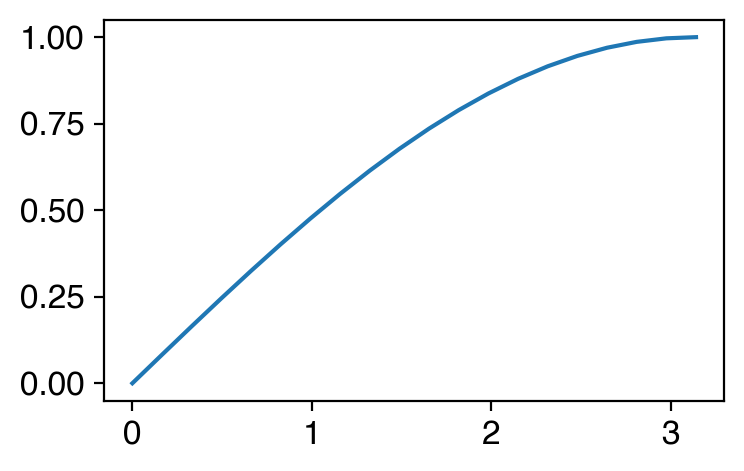

In [239]:
fig, ax = plt.subplots()
ax.plot(angles, concurrence)

### Create training and test set

In [240]:
X_train, X_test, y_train, y_test = train_test_split(density_matrices, np.ravel([[a] * num_samples for a in angles]), random_state=42)

Define Hyperparameters:

In [241]:
batch_size = 64
beta = 0.75
learning_rate = 5e-5
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"
num_epochs = 100

Load trained VAE:

In [242]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

vae_noisy = VAE(encoder, decoder, beta)
vae_noisy.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))

In [243]:
for e in range(num_epochs):
    vae_noisy.fit(X_test, epochs=1, batch_size=batch_size, verbose=1) 

 1/79 [..............................] - ETA: 30s - loss: 0.4779 - reconstruction_loss: 0.3633 - kl_loss: 0.1528

InvalidArgumentError: Graph execution error:

Detected at node 'GatherV2' defined at (most recent call last):
    File "/Users/evert/opt/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/evert/opt/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/evert/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/evert/opt/miniconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/evert/opt/miniconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/6b/6zwm_c71257c5xj9nrgdfs840000gn/T/ipykernel_29056/4246131224.py", line 2, in <module>
      vae_noisy.fit(X_test, epochs=1, batch_size=batch_size, verbose=1)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/evert/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/var/folders/6b/6zwm_c71257c5xj9nrgdfs840000gn/T/ipykernel_29056/973750214.py", line 81, in train_step
      tf.reduce_sum(tf.keras.losses.mean_squared_error(tf.gather(data, indices=[0,5,10,15]), tf.gather(reconstruction, indices=[0,5,10,15])), axis=-1))
Node: 'GatherV2'
indices[2] = 10 is not in [0, 8)
	 [[{{node GatherV2}}]] [Op:__inference_train_function_709221]

In [156]:
z_mean, z_log_var, z = vae_noisy.encoder.predict(X_test)

782/782 [==============================] - 0s 227us/step


Investigate Latent Space

In [157]:
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

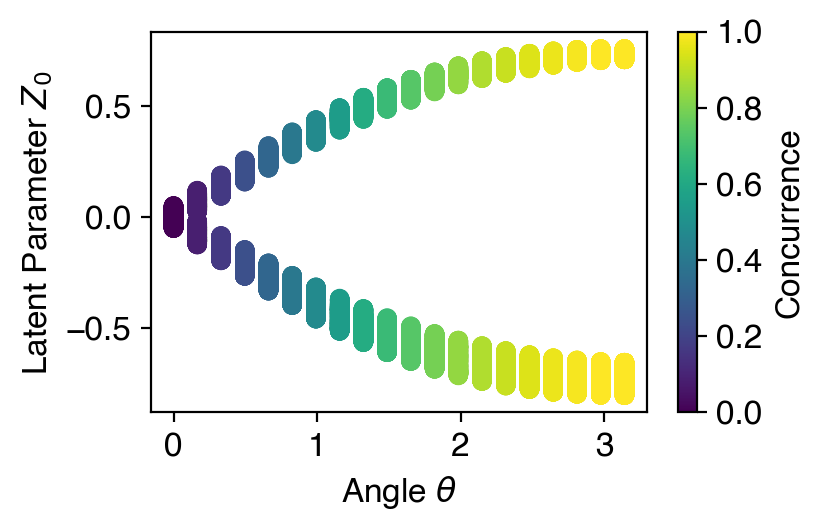

In [158]:

plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

In [187]:
dm1 = get_dm(0.3)
dm1t = qt.Qobj(dm1.data,dims=[[2,2],[2,2]])
dm2 = get_dm(0.2)
dm2t = qt.Qobj(dm2.data,dims=[[2,2],[2,2]])

concurrence_slope = (qt.concurrence(dm1t) - qt.concurrence(dm2t))/(0.3-0.2)

z_mean, z_log_var, z = vae_noisy.encoder.predict(np.reshape(dm1, (1,-1)))
cp1 = np.abs(z_mean[0][0])
z_mean, z_log_var, z = vae_noisy.encoder.predict(np.reshape(dm2, (1,-1)))
cp2 = np.abs(z_mean[0][0])

predicted_slope = (cp1 - cp2)/(0.3-0.2)

print(concurrence_slope)
print(predicted_slope)

rescaled_prediction = cp2 * (concurrence_slope/predicted_slope)
offset = qt.concurrence(dm2t) - rescaled_prediction

print(offset)

def rescale(a):
    return a*(concurrence_slope/predicted_slope) + offset

print(rescale(cp2), qt.concurrence(dm2t))

1/1 [==============================] - 0s 8ms/step
0.4960471511649632
0.4109071195125581
0.04566114029181416
0.09983341627277859 0.09983341627277859


### Test trained VAE on predicting concurrence of fully random DMs

In [171]:
errors = []
concurrences = []
predictions = []
for i in range(100):
    dm = get_dm(np.random.uniform(0,np.pi))
    dm = qt.Qobj(dm.data,dims=[[2,2],[2,2]])
    UaUb = qt.Qobj(get_random_u(4),dims = [[2, 2], [2, 2]])
    random_density_matrix = np.real(apply_u(dm, UaUb))

    concurrence = qt.concurrence(qt.Qobj(random_density_matrix, dims=[[2,2],[2,2]]))
    z_mean, z_log_var, z = vae_noisy.encoder.predict(np.reshape(random_density_matrix, (1,-1)))
    errors.append(np.abs(concurrence - np.abs(z_mean[0][0])))
    
    concurrences.append(concurrence)
    predictions.append(np.abs(z_mean[0][0]))

1/1 [==============================] - 0s 6ms/step


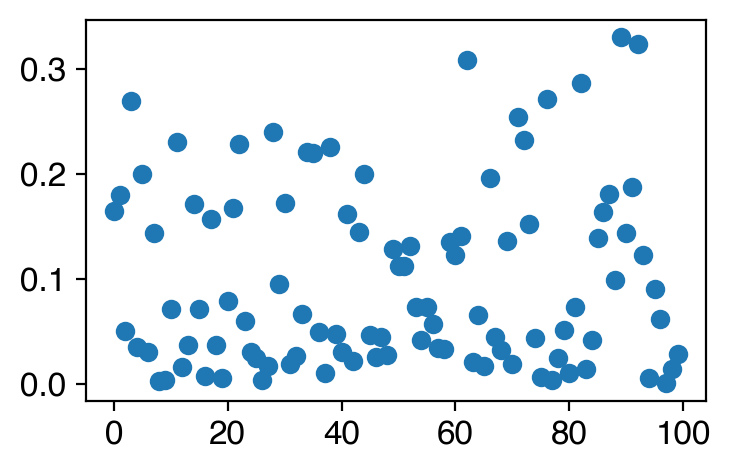

In [170]:
plt.scatter(range(len(errors)),errors)

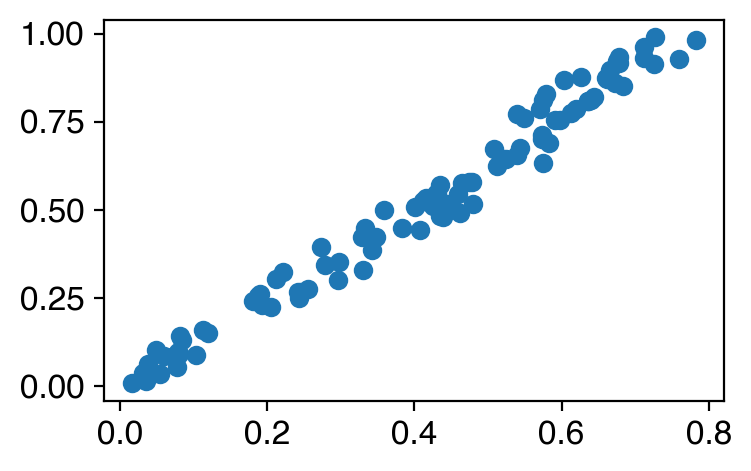

In [172]:
plt.scatter(predictions, concurrences)

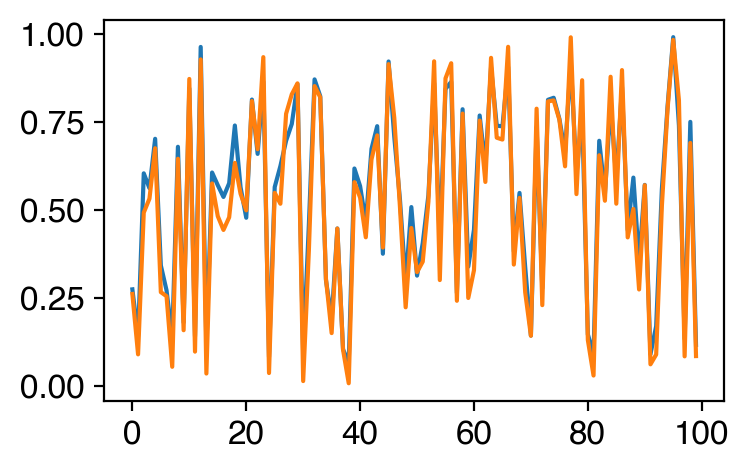

In [190]:
plt.plot([rescale(a) for a in predictions])
plt.plot(concurrences)